In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import least_squares
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal
import arch

from model.PDV import *
from model.data import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download data

In [2]:
load_from = pd.to_datetime('1995-01-01')  # Need at least 4 years prior to the first training day
train_start_date = pd.to_datetime('1995-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [3]:
# # Load data on SPX and VIX
# spx_data = yf.Ticker("^GSPC").history(start=load_from, end=test_end_date)
# vix_data = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)

In [4]:
# spx_data.to_csv('spx_data.csv')
# vix_data.to_csv('vix_data.csv')

In [5]:
spx_data = pd.read_csv('data/spx_data.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('data/vix_data.csv', index_col=0, parse_dates=[0])

In [6]:
data = create_df_from_yf(spx_data, train_start_date, test_start_date, vix_df=vix_data, log_return=True)
data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2018-12-24,-0.027487,7.555117e-04,0.3607
2018-12-26,0.048403,2.342868e-03,0.3041
2018-12-27,0.008526,7.269658e-05,0.2996
2018-12-28,-0.001242,1.543443e-06,0.2834


In [7]:
window = 100
dataset = VIXDataset(data, window)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Fitting

## SGD

In [8]:
# params = torch.tensor([0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5], requires_grad=True)
# optimizer = torch.optim.Adam([params], lr=0.01)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)

# for epoch in range(100):
#     losses = []
#     for x, y in dataloader:
#         preds = torch_predict(params, x)
#         loss = nn.MSELoss()(preds, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
#     epoch_loss = np.mean(losses)
#     print(f'Epoch {epoch} Loss {epoch_loss}')
#     scheduler.step(epoch_loss)

In [9]:
# print(params)
# evaluate(params.detach().numpy(), data, window)

## Least squares

In [10]:
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
# initial_x = [0.1, -1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5]
initial_x = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
res = least_squares(residual, initial_x, args=(data, window), bounds=(lower_bound, upper_bound), verbose=2, ftol=1e-6)
res.x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9944e+00                                    2.02e+02    
       1              2         2.6414e+00      3.35e+00       6.47e+00       3.34e+01    
       2              3         2.2864e+00      3.55e-01       1.93e-02       2.68e+01    
       3              4         2.0963e+00      1.90e-01       8.94e+00       1.55e+01    
       4              7         2.0539e+00      4.24e-02       4.98e-01       2.90e+00    
       5              8         2.0455e+00      8.44e-03       5.68e+00       6.44e+00    
       6              9         2.0413e+00      4.17e-03       6.20e+00       9.60e+00    
       7             10         2.0288e+00      1.25e-02       5.82e+00       5.93e+00    
       8             11         2.0234e+00      5.41e-03       2.00e+00       1.45e+00    
       9             15         2.0228e+00      5.46e-04       1.09e-01       5.54e-01    

array([ 6.49191071e-02, -2.02792399e-02,  5.23609988e+00,  4.46563325e+01,
        1.41075827e+01,  1.37548726e-32,  1.70470047e+01,  1.90411769e-02,
        9.82963474e-01])

In [11]:
evaluate(res.x, data, window)

Mean: 0.0000, Min: -0.1113, Max: 0.1169, MAE: 0.0205, MSE: 0.0007, R^2: 0.8991


# Neural network to model log of ratio residuals (y/y_hat)


In [17]:
res_window = 20

In [13]:
residuals, y_hat = residual(res.x, data, window, return_y_hat=True)
vix = residuals + y_hat
ratio_residuals = vix / y_hat
log_ratio_residuals = np.log(ratio_residuals)
log_ratio_residuals.shape

(5942,)

In [14]:
# # create validation set
preds = predict(*res.x, data, window)
df_preds = data[window-1:].copy()
df_preds['preds'] = preds
df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
df_preds['log_ratio'] = np.log(df_preds['ratio'])
df_preds

,r1,r2,vix,preds,residuals,ratio,log_ratio
1995-05-25,-0.000038,1.425612e-09,0.1163,0.123689,-0.007389,0.940263,-0.061596
1995-05-26,-0.009390,8.816395e-05,0.1220,0.137379,-0.015379,0.888052,-0.118725
1995-05-30,-0.000134,1.787569e-08,0.1252,0.132332,-0.007132,0.946104,-0.055403
1995-05-31,0.018582,3.452829e-04,0.1285,0.133654,-0.005154,0.961441,-0.039322
1995-06-01,0.000169,2.844302e-08,0.1221,0.133784,-0.011684,0.912667,-0.091384
...,...,...,...,...,...,...,...
2018-12-24,-0.027487,7.555117e-04,0.3607,0.321573,0.039127,1.121674,0.114822
2018-12-26,0.048403,2.342868e-03,0.3041,0.304236,-0.000136,0.999553,-0.000447
2018-12-27,0.008526,7.269658e-05,0.2996,0.292115,0.007485,1.025624,0.025301
2018-12-28,-0.001242,1.543443e-06,0.2834,0.288627,-0.005227,0.981889,-0.018277


In [48]:
ma_model = arch.univariate.arch_model(df_preds['log_ratio'], df_preds['vix'], mean='ARX', p=res_window, q=0)
ma_res = ma_model.fit()
ma_res.summary()

/Users/luchungi/opt/anaconda3/envs/signature/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.009956. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     25,   Neg. LLF: 38557.92868919411
Iteration:      2,   Func. Count:     54,   Neg. LLF: 14227.955442710621
Iteration:      3,   Func. Count:     82,   Neg. LLF: 3629.1932114792794
Iteration:      4,   Func. Count:    110,   Neg. LLF: 1167.4755721233196
Iteration:      5,   Func. Count:    136,   Neg. LLF: 93969.89897848094
Iteration:      6,   Func. Count:    161,   Neg. LLF: 479368.5464874669
Iteration:      7,   Func. Count:    186,   Neg. LLF: -5246.679777750882
Iteration:      8,   Func. Count:    211,   Neg. LLF: -1275.7974543798666
Iteration:      9,   Func. Count:    236,   Neg. LLF: 77823798.82188335
Iteration:     10,   Func. Count:    268,   Neg. LLF: 455296.83545932686
Iteration:     11,   Func. Count:    299,   Neg. LLF: 12373536.545801695
Iteration:     12,   Func. Count:    329,   Neg. LLF: 45636.19925794857
Iteration:     13,   Func. Count:    359,   Neg. LLF: 34060819.81315239
Iteration:     14,   Func. Count:    389,   Neg. LLF: 28

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR-X - ARCH Model Results                           
==============================================================================
Dep. Variable:              log_ratio   R-squared:                       0.000
Mean Model:                      AR-X   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:                7995.18
Distribution:                  Normal   AIC:                          -15944.4
Method:            Maximum Likelihood   BIC:                          -15787.4
                                        No. Observations:                 6791
Date:                Mon, Oct 21 2024   Df Residuals:                     6789
Time:                        17:55:49   Df Model:                            2
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -4.7428e-04  3.004e-03     -0.158      0.875 [-6.361e-03,5.413e-03]
vix         9.6961e-03  9.795e-03      0.990      0.322 [-9.501e-03,2.889e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.9186e-03  1.158e-03      3.385  7.128e-04 [1.649e-03,6.188e-03]
alpha[1]       0.2847      0.394      0.722      0.470     [ -0.488,  1.057]
alpha[2]   6.5735e-03      0.156  4.203e-02      0.966     [ -0.300,  0.313]
alpha[3]   6.2886e-03      0.480  1.310e-02      0.990     [ -0.934,  0.947]
alpha[4]   6.2287e-03  8.841e-02  7.045e-02      0.944     [ -0.167,  0.180]
alpha[5]       0.1058      0.348      0.304      0.761     [ -0.577,  0.788]
alpha[6]   6.1834e-03      0.222  2.780e-02      0.978     [ -0.430,  0.442]
alpha[7]   6.1866e-03      0.196  3.155e-02      0.975     [ -0.378,  0.391]
alpha[8]   6.0822e-03      0.354  1.718e-02      0.986     [ -0.688,  0.700]
alpha[9]   6.0587e-03      0.538  1.126e-02      0.991     [ -1.048,  1.061]
alpha[10]  6.0386e-03      1.573  3.838e-03      0.997     [ -3.078,  3.090]
alpha[11]  6.0147e-03      0.519  1.159e-02      0.991     [ -1.011,  1.024]
alpha[12]  6.0378e-03      0.584  1.034e-02      0.992     [ -1.138,  1.150]
alpha[13]  6.0690e-03      0.401  1.514e-02      0.988     [ -0.780,  0.792]
alpha[14]  6.0568e-03  5.756e-02      0.105      0.916     [ -0.107,  0.119]
alpha[15]  6.0214e-03      0.170  3.551e-02      0.972     [ -0.326,  0.338]
alpha[16]  6.0146e-03      0.705  8.529e-03      0.993     [ -1.376,  1.388]
alpha[17]  5.9922e-03      0.242  2.479e-02      0.980     [ -0.468,  0.480]
alpha[18]  6.0721e-03      0.359  1.693e-02      0.986     [ -0.697,  0.709]
alpha[19]  6.1056e-03  8.674e-02  7.039e-02      0.944     [ -0.164,  0.176]
alpha[20]  6.1168e-03      0.154  3.977e-02      0.968     [ -0.295,  0.308]
============================================================================

Covariance estimator: robust
"""

# Predicting out of sample

In [16]:
full_data = create_df_from_yf(spx_data, train_start_date, test_end_date, vix_df=vix_data, log_return=True)
full_data

,r1,r2,vix
1995-01-04,0.003479,1.210315e-05,0.1353
1995-01-05,-0.000803,6.454842e-07,0.1350
1995-01-06,0.000738,5.450927e-07,0.1313
1995-01-09,0.000326,1.059759e-07,0.1333
1995-01-10,0.001843,3.395957e-06,0.1252
...,...,...,...
2022-05-09,-0.032562,1.060253e-03,0.3475
2022-05-10,0.002455,6.026444e-06,0.3299
2022-05-11,-0.016600,2.755677e-04,0.3256
2022-05-12,-0.001297,1.681703e-06,0.3177


In [46]:
preds = predict(*res.x, full_data, window)
df_preds = full_data[window-1:].copy()
df_preds['preds'] = preds
df_preds['residuals'] = df_preds['vix'] - df_preds['preds']
df_preds['ratio'] = df_preds['vix'] / df_preds['preds']
df_preds['log_ratio'] = np.log(df_preds['ratio'])
df_preds.iloc[res_window:, -1] = np.NaN
df_preds[res_window-1:]

,r1,r2,vix,preds,residuals,ratio,log_ratio
1995-06-22,0.012949,0.000168,0.1144,0.125536,-0.011136,0.911292,-0.092891
1995-06-23,-0.002471,0.000006,0.1112,0.129124,-0.017924,0.861189,NaN
1995-06-26,-0.010203,0.000104,0.1180,0.144975,-0.026975,0.813932,NaN
1995-06-27,-0.003129,0.000010,0.1237,0.147084,-0.023384,0.841014,NaN
1995-06-28,0.004231,0.000018,0.1174,0.142215,-0.024815,0.825511,NaN
...,...,...,...,...,...,...,...
2022-05-09,-0.032562,0.001060,0.3475,0.350728,-0.003228,0.990797,NaN
2022-05-10,0.002455,0.000006,0.3299,0.338454,-0.008554,0.974726,NaN
2022-05-11,-0.016600,0.000276,0.3256,0.349547,-0.023947,0.931490,NaN
2022-05-12,-0.001297,0.000002,0.3177,0.340538,-0.022838,0.932936,NaN


In [47]:
simulations = ma_res.forecast(horizon=len(df_preds.iloc[res_window:, -1]), method='simulation', simulations=1)
log_residuals = simulations.simulations.values.squeeze()
df_preds.iloc[res_window:, -1] = log_residuals
df_preds[res_window-1:]

,r1,r2,vix,preds,residuals,ratio,log_ratio
1995-06-22,0.012949,0.000168,0.1144,0.125536,-0.011136,0.911292,-0.092891
1995-06-23,-0.002471,0.000006,0.1112,0.129124,-0.017924,0.861189,-0.034505
1995-06-26,-0.010203,0.000104,0.1180,0.144975,-0.026975,0.813932,-0.014066
1995-06-27,-0.003129,0.000010,0.1237,0.147084,-0.023384,0.841014,-0.003528
1995-06-28,0.004231,0.000018,0.1174,0.142215,-0.024815,0.825511,-0.006478
...,...,...,...,...,...,...,...
2022-05-09,-0.032562,0.001060,0.3475,0.350728,-0.003228,0.990797,-0.004343
2022-05-10,0.002455,0.000006,0.3299,0.338454,-0.008554,0.974726,-0.045584
2022-05-11,-0.016600,0.000276,0.3256,0.349547,-0.023947,0.931490,-0.120682
2022-05-12,-0.001297,0.000002,0.3177,0.340538,-0.022838,0.932936,-0.119419


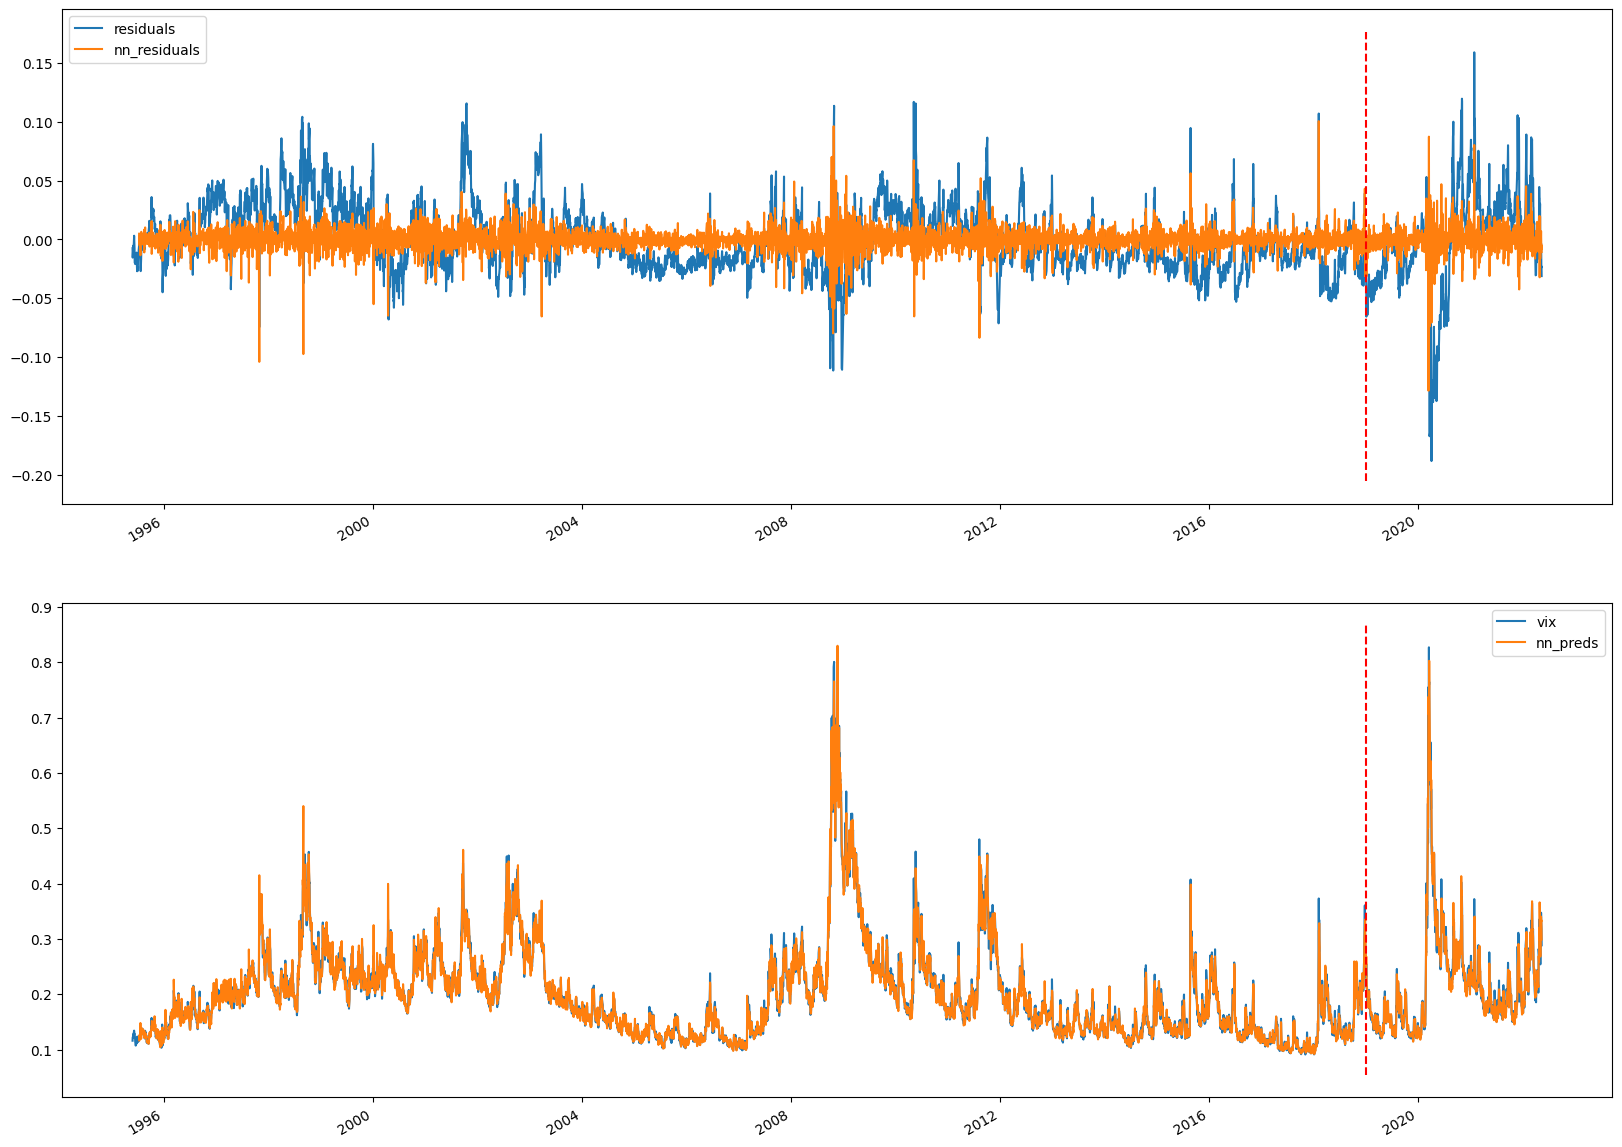

In [150]:
fig, ax = plt.subplots(2, 1, figsize=(20, 16))
df_preds[['residuals', 'nn_residuals']].plot(ax=ax[0])
df_preds[['vix', 'nn_preds']].plot(ax=ax[1])
ax[0].vlines(test_start_date, ax[0].get_ylim()[0], ax[0].get_ylim()[-1], linestyles='dashed', colors='red')
ax[1].vlines(test_start_date, ax[1].get_ylim()[0], ax[1].get_ylim()[-1], linestyles='dashed', colors='red')


<Axes: >

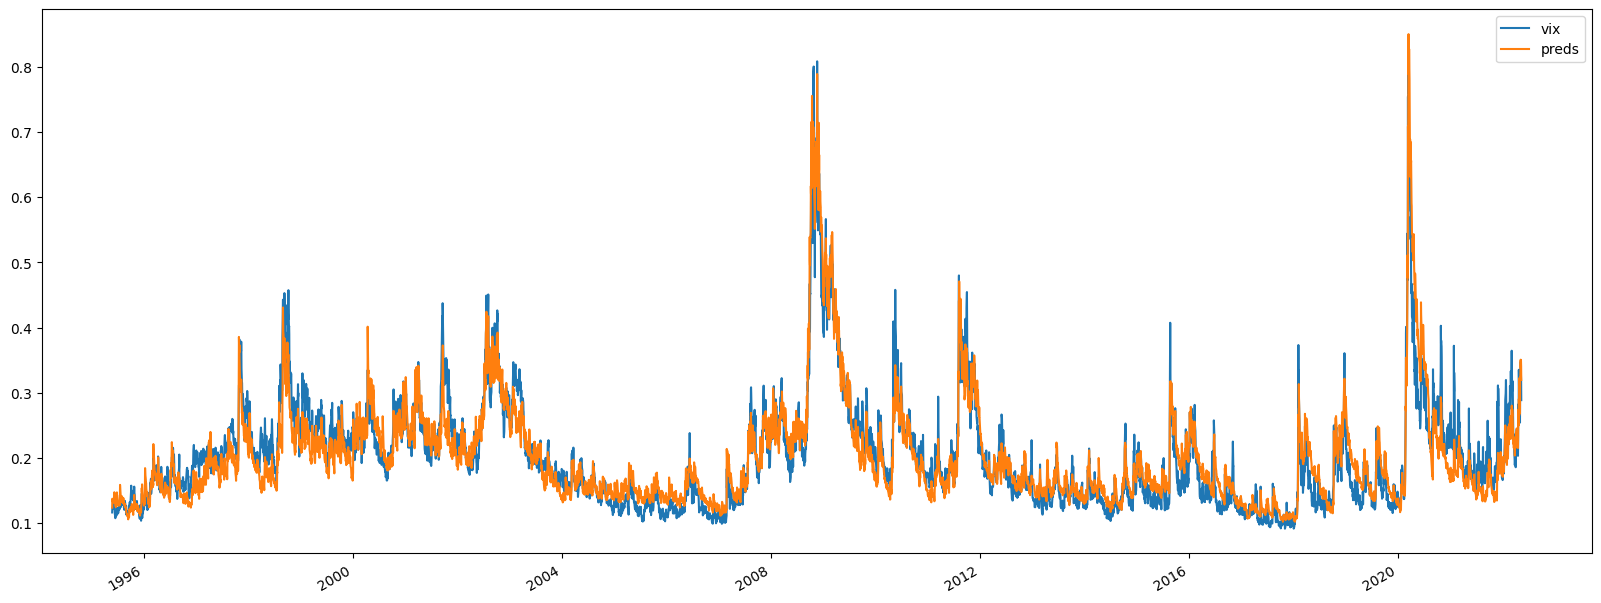

In [151]:
df_preds[['vix', 'preds']].plot(figsize=(20, 8))